## Data Preprocessing


In [87]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from skimage.morphology import skeletonize


IMG_SIZE = (64, 64)


def show(img):
    plt.imshow(img)
    plt.show()


def remove_lines(img):
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([50, 50, 50])  # Adjust as needed based on line intensity
    mask = cv2.inRange(img, lower_black, upper_black)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_inpainted = cv2.inpaint(gray, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return img_inpainted


def crop(img):
    _, thresh = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY_INV)
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    cropped_image = img[y : y + h, x : x + w]
    return cropped_image


def remove_noise(img):
    """
    Removes noise from the image using a combination of morphological operations
    and filtering techniques.
    """
    # Convert to grayscale and invert
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    inverted = cv2.bitwise_not(gray)

    # Initial erosion to weaken noise
    kernel = np.ones((2, 2), np.uint8)
    eroded = cv2.erode(inverted, kernel, iterations=1)

    # Median filtering to remove lines and circles
    vertical_filtered = cv2.medianBlur(eroded, 5)  # Vertical filter
    horizontal_filtered = cv2.medianBlur(vertical_filtered, 3)  # Horizontal filter

    # Dilate to restore characters
    dilated = cv2.dilate(horizontal_filtered, kernel, iterations=1)

    # Final median filter to clean up
    cleaned = cv2.medianBlur(dilated, 3)

    # Remove remaining circles using Hough transform
    circles = cv2.HoughCircles(
        cleaned,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=1,
        param1=50,
        param2=30,
        minRadius=0,
        maxRadius=2,
    )

    if circles is not None:
        circles = np.uint16(np.around(circles))
        mask = np.ones_like(cleaned)
        for i in circles[0, :]:
            cv2.circle(mask, (i[0], i[1]), i[2], 0, -1)
        cleaned = cleaned * mask

    # Final morphological operations
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(cleaned, kernel, iterations=1)
    vertical_filtered = cv2.medianBlur(eroded, 5)
    dilated = cv2.dilate(vertical_filtered, kernel, iterations=2)
    final = cv2.erode(dilated, kernel, iterations=1)

    return final


def segment_characters(img):
    """
    Segments characters using connected components and watershed algorithm.
    Returns a list of character images.
    """
    # Find connected components
    num_labels, labels = cv2.connectedComponents(img)

    # Initialize markers for watershed
    markers = np.zeros(img.shape, dtype=np.int32)

    # Process components
    char_regions = []
    for label in range(1, num_labels):
        mask = (labels == label).astype(np.uint8) * 255
        pixel_count = np.sum(mask > 0)

        # Filter out noise (too small) and handle joint characters (too large)
        if pixel_count < 100:  # Noise
            continue
        elif pixel_count >= 2200:  # Joint characters
            # Split into two characters
            h, w = mask.shape
            left_mask = mask[:, : w // 2]
            right_mask = mask[:, w // 2 :]
            char_regions.extend([left_mask, right_mask])
        else:
            char_regions.append(mask)

    # Ensure exactly 4 characters
    if len(char_regions) != 4:
        return None

    # Squarify characters
    squared_chars = []
    target_size = (76, 76)
    for char in char_regions:
        h, w = char.shape

        # Create square background
        square = np.zeros(target_size, dtype=np.uint8)

        # Calculate padding
        pad_top = (target_size[0] - h) // 2
        pad_left = (target_size[1] - w) // 2

        # Place character in center
        square[pad_top : pad_top + h, pad_left : pad_left + w] = char
        squared_chars.append(square)

    return squared_chars


def preprocess_captcha(img):
    """
    Main preprocessing function that combines noise removal and character segmentation.
    """
    # Remove noise
    cleaned = remove_noise(img)

    # Segment characters
    characters = segment_characters(cleaned)

    return characters


def preprocess_image(img):
    """
    Preprocesses an image through binarization, denoising, and thinning.

    Args:
        img: Input image (BGR or grayscale)

    Returns:
        numpy.ndarray: Preprocessed binary image
    """
    # Convert to grayscale if not already
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    # Step 1: Binarization using Otsu's method
    # Otsu automatically determines optimal threshold value
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Step 2: Denoising
    # First apply median blur to remove salt-and-pepper noise
    denoised = cv2.medianBlur(binary, 3)
    # Then use morphological opening to remove small noise and smooth edges
    kernel = np.ones((3, 3), np.uint8)
    denoised = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel)

    # Step 3: Thinning
    # Convert to boolean array for skeletonization
    binary_for_skeleton = denoised > 0
    skeleton = skeletonize(binary_for_skeleton)

    # Convert back to uint8 format (0-255)
    result = (skeleton * 255).astype(np.uint8)

    return result


def segment_save(img, filename, destination_path):
    # Get the correct characters from filename
    captcha_contents = filename.split("-")[0]
    chars = list(captcha_contents)

    # Create character directories if they don't exist
    for char in chars:
        class_path = os.path.join(destination_path, char)
        if not os.path.exists(class_path):
            os.makedirs(class_path)

    height, width = img.shape
    num_portions = len(chars)
    portion_width = width // num_portions

    for i in range(num_portions):
        # Segment
        x_start = i * portion_width
        x_end = x_start + portion_width
        portion = img[:, x_start:x_end]

        # Resize (keras will do it for us apparently)
        portion = cv2.resize(portion, IMG_SIZE, interpolation=cv2.INTER_AREA)

        # Threshold the image to make sure everything is black and white
        _, portion = cv2.threshold(portion, 240, 255, cv2.THRESH_BINARY_INV)

        # Save
        char_filename = f"{chars[i]}/{chars[i]}_0.png"
        char_filepath = os.path.join(destination_path, char_filename)
        counter = 0
        while os.path.exists(char_filepath):
            char_filename = f"{chars[i]}/{chars[i]}_{counter}.png"
            char_filepath = os.path.join(destination_path, char_filename)
            counter += 1
        cv2.imwrite(char_filepath, portion)


def segment_save_better(img, filename, destination_path):
    """
    Segments and saves individual characters from a captcha image using contour detection.

    Args:
        img: Grayscale input image
        filename: Original filename containing the captcha text
        destination_path: Path to save the segmented characters
    """
    # Get the correct characters from filename
    captcha_contents = filename.split("-")[0]
    chars = list(captcha_contents)

    # Create character directories if they don't exist
    for char in chars:
        class_path = os.path.join(destination_path, char)
        if not os.path.exists(class_path):
            os.makedirs(class_path)

    # Get image dimensions and calculate portions
    height, width = img.shape
    num_portions = len(chars)
    portion_width = width // num_portions

    # Add padding around the image
    img = cv2.copyMakeBorder(img, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # Threshold the image
    _, thresh = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(
        thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # If contour detection fails, fall back to simple division method
    if len(contours) != len(chars):
        for i in range(num_portions):
            # Segment
            x_start = i * portion_width
            x_end = x_start + portion_width
            portion = img[:, x_start:x_end]

            # Ensure portion is not empty
            if portion.size == 0:
                continue

            # Resize
            portion = cv2.resize(portion, IMG_SIZE, interpolation=cv2.INTER_AREA)

            # Threshold
            _, portion = cv2.threshold(portion, 240, 255, cv2.THRESH_BINARY_INV)

            # Save
            counter = 0
            while True:
                char_filename = f"{chars[i]}/{chars[i]}_{counter}.png"
                char_filepath = os.path.join(destination_path, char_filename)
                if not os.path.exists(char_filepath):
                    cv2.imwrite(char_filepath, portion)
                    break
                counter += 1
        return

    # Sort contours left-to-right
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    # Process each contour
    for i, contour in enumerate(contours):
        if i >= len(chars):  # Safety check
            break

        x, y, w, h = cv2.boundingRect(contour)

        # Extract character
        char_image = img[y : y + h, x : x + w]

        # Ensure char_image is not empty
        if char_image.size == 0:
            continue

        # Resize
        char_image = cv2.resize(char_image, IMG_SIZE, interpolation=cv2.INTER_AREA)

        # Threshold
        _, char_image = cv2.threshold(char_image, 240, 255, cv2.THRESH_BINARY_INV)

        # Save
        counter = 0
        while True:
            char_filename = f"{chars[i]}/{chars[i]}_{counter}.png"
            char_filepath = os.path.join(destination_path, char_filename)
            if not os.path.exists(char_filepath):
                cv2.imwrite(char_filepath, char_image)
                break
            counter += 1


def print_char_stats(chars_path):
    classes = os.listdir(chars_path)

    # Initialize a counter to track the occurrences of each character
    character_counter = Counter()

    # Loop through each file in the folder
    for folder in classes:
        for char in folder:
            # Make sure the file is a valid image (you can adjust the file extension if needed)
            if char.endswith(".png"):
                # Extract the character label from the filename (assuming filename format like 'a_1.png')
                character_label = char.split("_")[
                    0
                ]  # Adjust based on your filename format

                # Update the counter with the extracted character label
                character_counter[character_label] += 1

    # Total number of characters (images)
    total_characters = sum(character_counter.values())

    # Number of unique classes (characters)
    num_classes = len(classes)

    # Print statistics
    print(f"Total number of characters: {total_characters}")
    print(f"Number of unique classes (characters): {num_classes}")
    print("\nCharacter distribution:")
    for character, count in character_counter.items():
        print(f"Character '{character}': {count} instances")

    return num_classes

In [8]:
folder_path = "./dataset/"  # change this to your dataset folder
main_path = folder_path + "main/"
train_path = folder_path + "train/"
test_path = folder_path + "test/"
train_chars_path = folder_path + "train_chars/"
test_chars_path = folder_path + "test_chars/"

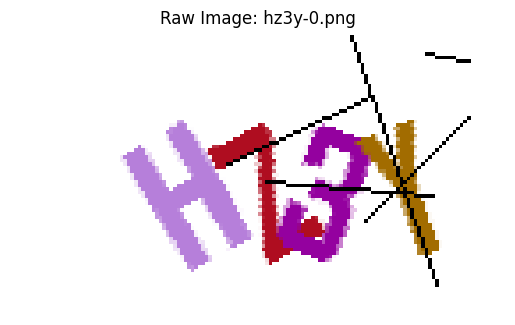

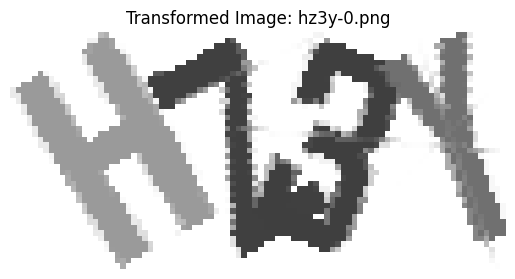

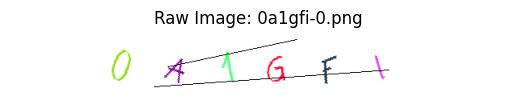

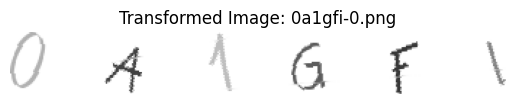

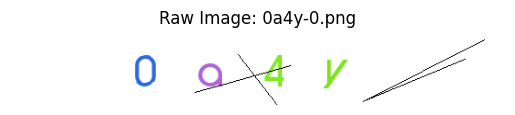

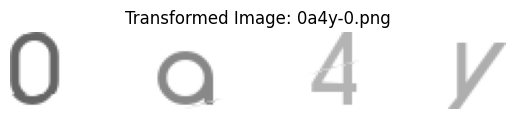

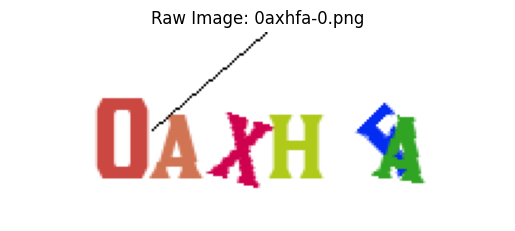

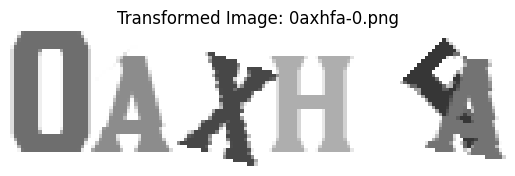

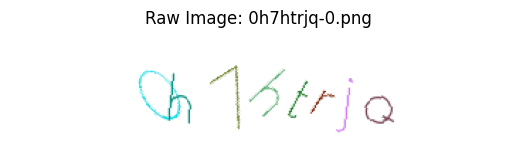

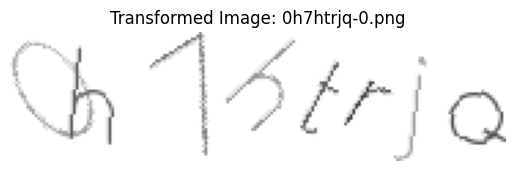

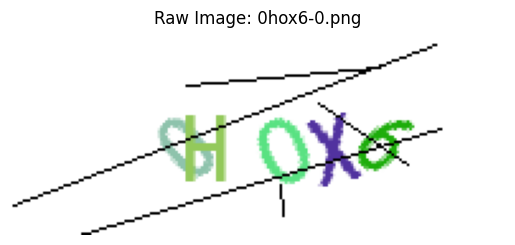

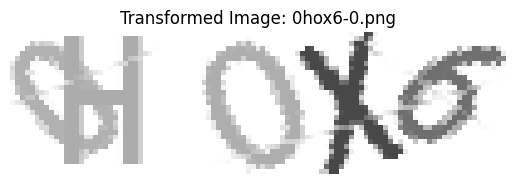

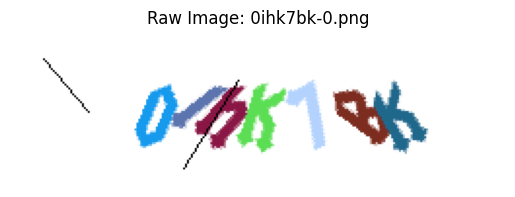

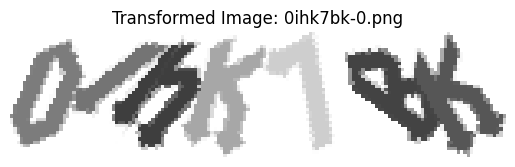

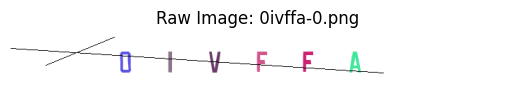

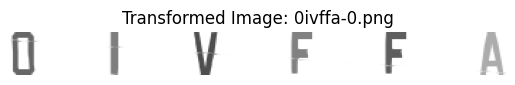

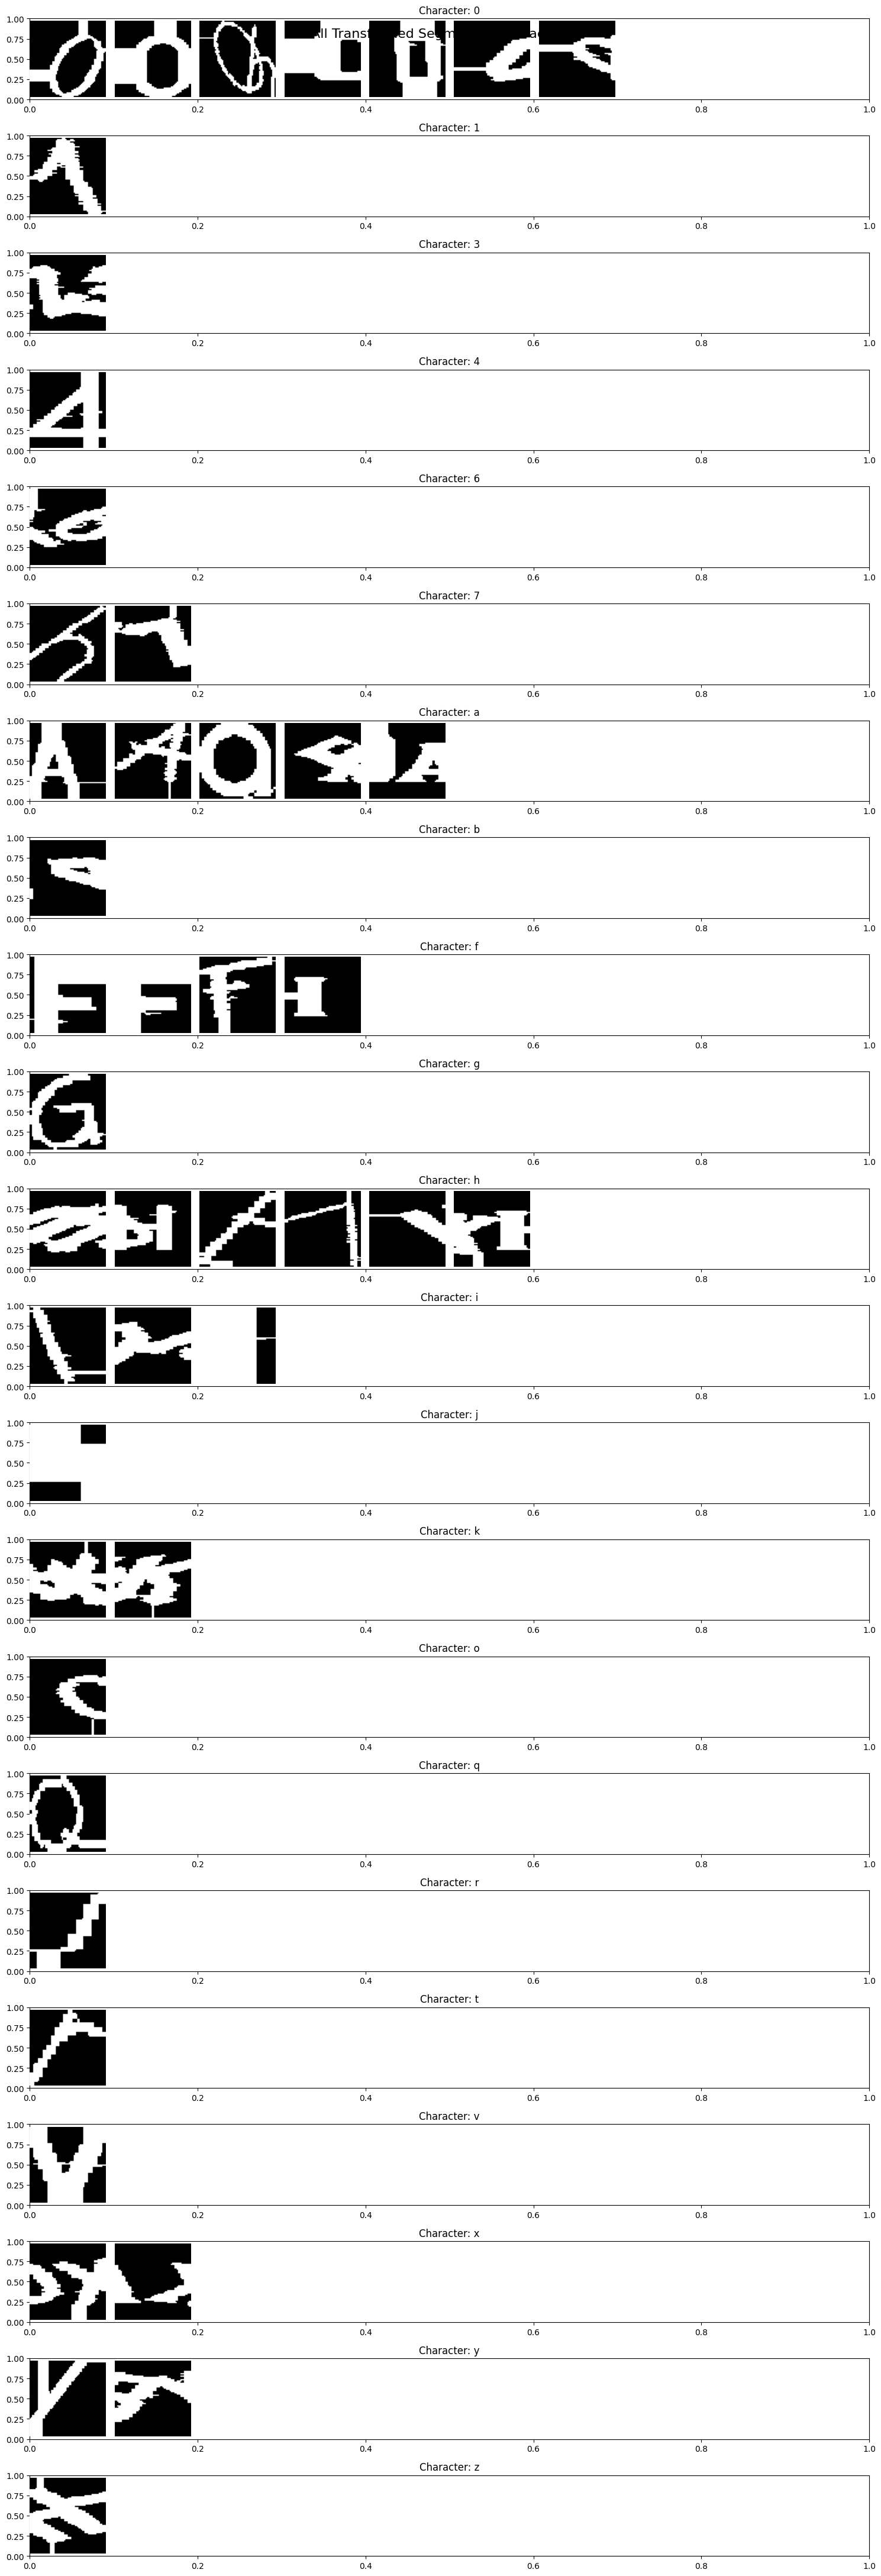

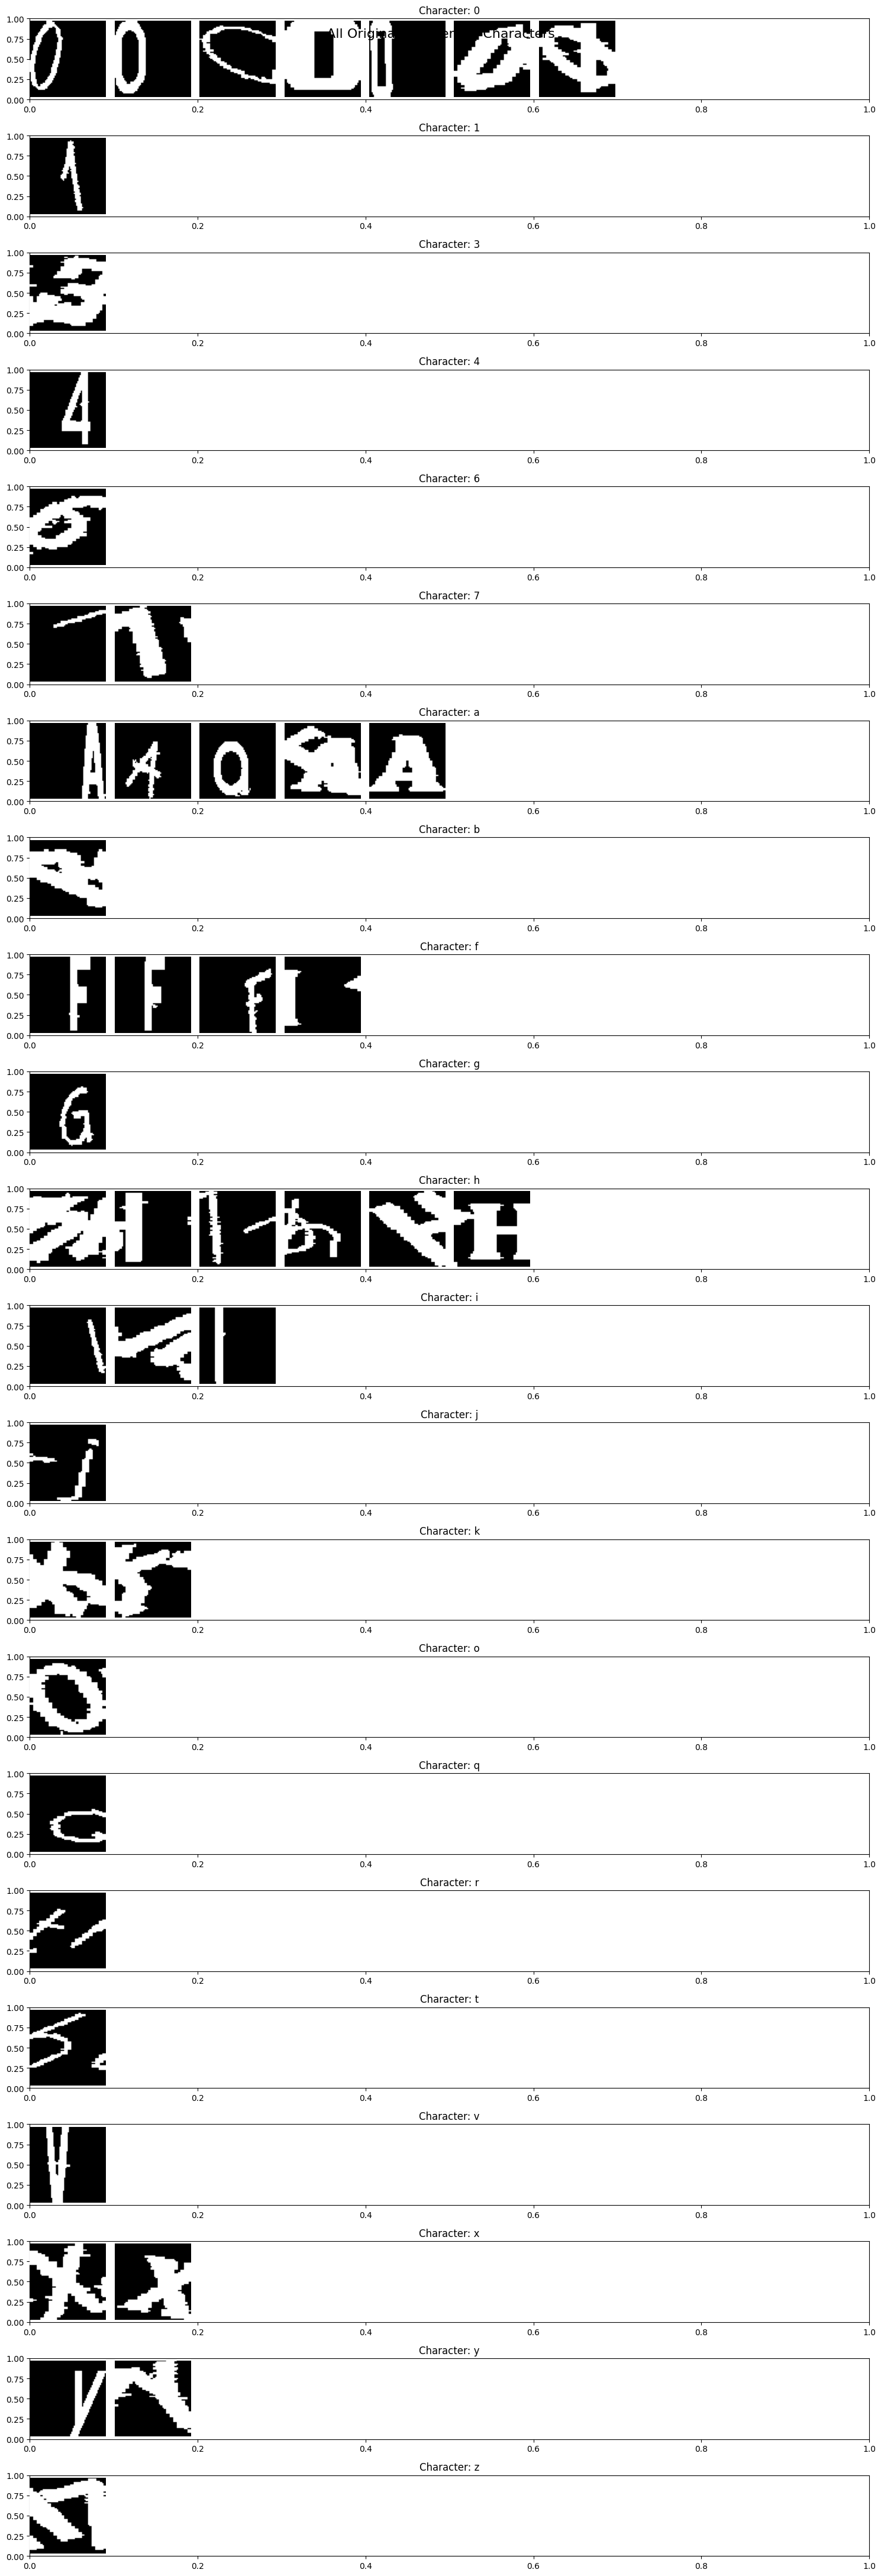

In [94]:
# Hardcode the test set of images from /train
import matplotlib.pyplot as plt
import shutil

test_images = [
    "hz3y-0.png",
    "0a1gfi-0.png",
    "0a4y-0.png",
    "0axhfa-0.png",
    "0h7htrjq-0.png",
    "0hox6-0.png",
    "0ihk7bk-0.png",
    "0ivffa-0.png",
]

# Clear the train_segments and train_segments_original folders
segments_path = "./dataset/train_segments/"
segments_original_path = "./dataset/train_segments_original/"
for path in [segments_path, segments_original_path]:
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

# Copy the test images to the test_chars_path and apply transformations
for image in test_images:
    src_path = os.path.join(train_path, image)
    dst_path = os.path.join("train_chars_individually/", image)

    # Check if the file exists before attempting to read
    if os.path.exists(src_path):
        # Read the image
        img = cv2.imread(src_path)

        if img is not None:
            # Display the raw image before transformation
            plt.figure()
            plt.title(f"Raw Image: {image}")
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis("off")  # Hide axes
            plt.show()

            # Apply transformations
            img_transformed = remove_lines(img)
            img_transformed = crop(img_transformed)
            # img_transformed = preprocess_image(img_transformed)
            # img_transformed = remove_noise(img_transformed)

            # Display the image after transformation
            plt.figure()
            plt.title(f"Transformed Image: {image}")
            plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
            plt.axis("off")  # Hide axes
            plt.show()

            # Save the transformed image
            cv2.imwrite(dst_path, img_transformed)

            # Save the original image to the original segments folder
            filename = os.path.basename(dst_path)
            segment_save(
                img_transformed, filename, destination_path=segments_original_path
            )

            # Save the transformed image to the segments folder
            segment_save_better(
                img_transformed, filename, destination_path=segments_path
            )

        else:
            print(
                f"Warning: Image {image} could not be read. Please check the file path or integrity."
            )
    else:
        print(f"Warning: Image {image} does not exist at path {src_path}.")


# Display all segmented characters from the segments folder
def display_segmented_characters(segments_path, title):
    characters = sorted(os.listdir(segments_path))  # Get all character folders

    plt.figure(figsize=(15, len(characters) * 2))
    plt.suptitle(title, fontsize=16)

    for idx, char in enumerate(characters):
        char_path = os.path.join(segments_path, char)
        if os.path.isdir(char_path):
            # Get all images for this character
            char_images = [f for f in os.listdir(char_path) if f.endswith(".png")]

            if char_images:
                # Create subplot for this character
                plt.subplot(len(characters), 1, idx + 1)
                plt.title(f"Character: {char}")

                # Display up to 10 examples side by side
                for i, img_name in enumerate(char_images[:10]):
                    img_path = os.path.join(char_path, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                    plt.subplot(len(characters), 10, idx * 10 + i + 1)
                    plt.imshow(img, cmap="gray")
                    plt.axis("off")
                    if i == 0:  # Only show character label for first image in row
                        plt.ylabel(char)

    plt.tight_layout()
    plt.show()


# Display segmented characters from both folders
display_segmented_characters(segments_path, "All Transformed Segmented Characters")
display_segmented_characters(
    segments_original_path, "All Original Segmented Characters"
)

In [36]:
import random
import shutil


## Same set of random images

# ... existing imports ...
import json

# Clear and recreate directories
if os.path.exists(train_chars_path):
    shutil.rmtree(train_chars_path)
os.makedirs(train_chars_path)

if os.path.exists(test_chars_path):
    shutil.rmtree(test_chars_path)
os.makedirs(test_chars_path)

# File paths for saving selected files
train_selection_file = os.path.join(folder_path, "selected_train_files.json")
test_selection_file = os.path.join(folder_path, "selected_test_files.json")

# Get or load training subset
if os.path.exists(train_selection_file):
    with open(train_selection_file, "r") as f:
        train_subset = json.load(f)
else:
    train_files = os.listdir(train_path)
    train_subset = random.sample(train_files, 200)
    with open(train_selection_file, "w") as f:
        json.dump(train_subset, f)

# Get or load test subset
if os.path.exists(test_selection_file):
    with open(test_selection_file, "r") as f:
        test_subset = json.load(f)
else:
    test_files = os.listdir(test_path)
    test_subset = random.sample(test_files, 50)
    with open(test_selection_file, "w") as f:
        json.dump(test_subset, f)

# Process training subset
for filename in train_subset:
    img = cv2.imread(os.path.join(train_path, filename))
    img = remove_lines(img)
    img = crop(img)
    segment_save(img, filename, train_chars_path)

# # Process test subset
# for filename in test_subset:
#     img = cv2.imread(os.path.join(test_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, test_chars_path)

# Print stats
print("Training set statistics:")
num_classes = print_char_stats(train_chars_path)
print("\nTest set statistics:")
print_char_stats(test_chars_path)

# # Wesley Version taking random smaller number of images for testing

# # Clear and recreate directories
# if os.path.exists(train_chars_path):
#     shutil.rmtree(train_chars_path)
# os.makedirs(train_chars_path)

# if os.path.exists(test_chars_path):
#     shutil.rmtree(test_chars_path)
# os.makedirs(test_chars_path)

# # Get random subset of training data
# train_files = os.listdir(train_path)
# train_subset = random.sample(train_files, 200)  # 40 for training

# # Process training subset
# for filename in train_subset:
#     img = cv2.imread(os.path.join(train_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, train_chars_path)

# # Get random subset of test data
# test_files = os.listdir(test_path)
# test_subset = random.sample(test_files, 50)  # 10 for testing

# # Process test subset
# for filename in test_subset:
#     img = cv2.imread(os.path.join(test_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, test_chars_path)

# # Print stats
# print("Training set statistics:")
# num_classes = print_char_stats(train_chars_path)
# print("\nTest set statistics:")
# print_char_stats(test_chars_path)

# # Segment captchas in training data and save to folder
# if not os.path.exists(train_chars_path):
#     os.makedirs(train_chars_path)

# data_files = os.listdir(train_path)

# for filename in data_files:
#     img = cv2.imread(os.path.join(train_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, train_chars_path)

# # Print Stats
# num_classes = print_char_stats(train_chars_path)

# # Segment captchas in test data and save to folder
# if not os.path.exists(test_chars_path):
#     os.makedirs(test_chars_path)

# data_files = os.listdir(test_path)

# for filename in data_files:
#     img = cv2.imread(os.path.join(test_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, test_chars_path)

Training set statistics:
Total number of characters: 0
Number of unique classes (characters): 36

Character distribution:

Test set statistics:
Total number of characters: 0
Number of unique classes (characters): 0

Character distribution:


0

## Augmenting Dataset


## Model


#### Initialise Model


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
# Init data
train_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
test_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

batch_size = 8  # 32 smaller batch size

train_generator = train_data.flow_from_directory(
    train_chars_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
)

test_generator = test_data.flow_from_directory(
    test_chars_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
)

Found 1224 images belonging to 36 classes.
Found 315 images belonging to 36 classes.


In [26]:
# Bare bones version
num_classes = 36
input_shape = (64, 64, 1)
model = Sequential(
    [
        Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        # 2nd Convolutional Block
        Conv2D(64, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        # 3rd Convolutional Block
        Conv2D(128, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(128, (1, 1), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        # Fully Connected Block
        Flatten(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)  # 0.002

model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True,  # 5 increase patience
)

#### Training Model


In [27]:
epochs = 50  # 100 reduce epoch size
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=early_stopping,
)
model.save("captcha-model.keras")

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.0213 - loss: 4.6924 - val_accuracy: 0.0190 - val_loss: 4.2246
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.0489 - loss: 4.0808 - val_accuracy: 0.0190 - val_loss: 4.5637
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.0747 - loss: 3.8339 - val_accuracy: 0.0381 - val_loss: 4.1014
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.0523 - loss: 3.7436 - val_accuracy: 0.0286 - val_loss: 3.8433
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.0735 - loss: 3.6018 - val_accuracy: 0.0571 - val_loss: 3.5225
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.0876 - loss: 3.4960 - val_accuracy: 0.0508 - val_loss: 3.5475
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.0938 - loss: 3.4183 - val_accuracy: 0.0508 - val_loss: 3.5004
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.0984 - loss: 3.3640 - val_accu

#### Evaluation


In [28]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Add more eval metrics here: captcha accuracy

 1/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7500 - loss: 1.2759

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4226 - loss: 2.4073
Test Accuracy: 37.46%


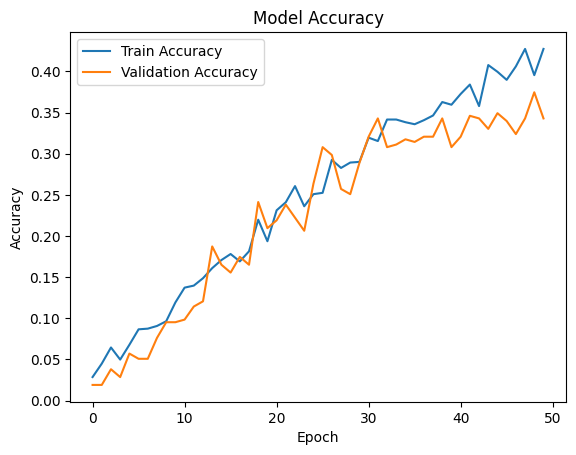

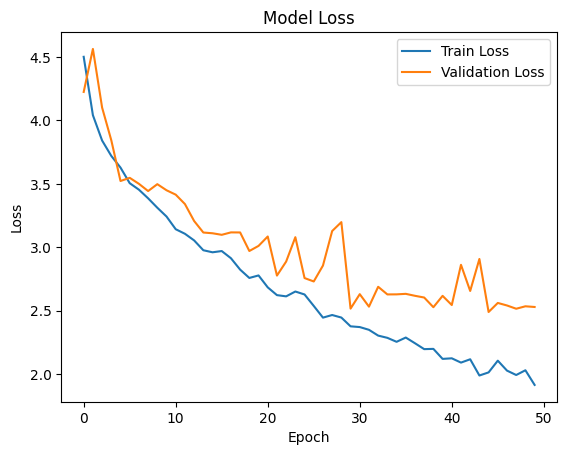

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.show()

# Plot training & validation loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")
plt.show()